<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Проект: Прогнозирование заказов такси

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

In [1]:
#df = pd.read_csv('###', index_col=[0], parse_dates=[0])

In [3]:
df.sort_index(inplace=True)

<b>Взглянем на исходный временный ряд</b>

<b>Напишем функцию, для отрисовки графика</b>

In [4]:
def plotly_df(df, title = ''):
    data = []
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [5]:
plotly_df(df)

In [6]:
fuller = adfuller(df['num_orders'])
fuller_output = pd.Series(fuller[0:4], index=['Test Statistic','p-value','#Lags Used',
                                              'Number of Observations Used'])
print(fuller_output)

<b>Вывод: Тест показывает, что ряд является стационарным</b>

<b>На графике почти незаметный тренд(медленное смещение среднего значения), есть сезонность и цикличность</b>

In [7]:
display(df.info())
display(df.head())

## Анализ

<b>Изучим исходные данные</b>

In [8]:
plotly_df(df['2018-03-01':'2018-03-06'])

<b>Здесь сезонность более заметна, ввиде пиков в начале нового дня, нижние пики в первой половине и середине дня</b>

In [9]:
display(df.values.mean())
display(df.values.var())

<b>Взглянем на ряд после ресемплирования по одному часу</b>

In [10]:
df_hour = df.resample('1H').sum()

In [11]:
plotly_df(df_hour['2018-03-01':'2018-03-06'])

<b>После ресемплирование график стал более сглаженным, визуально незашумлённый. На нём мы уже чётко видим пики на начало дня, нижний пик в первой половине дня и скачущий к следющему дню промежуток</b>

In [12]:
decomposed = seasonal_decompose(df_hour) 

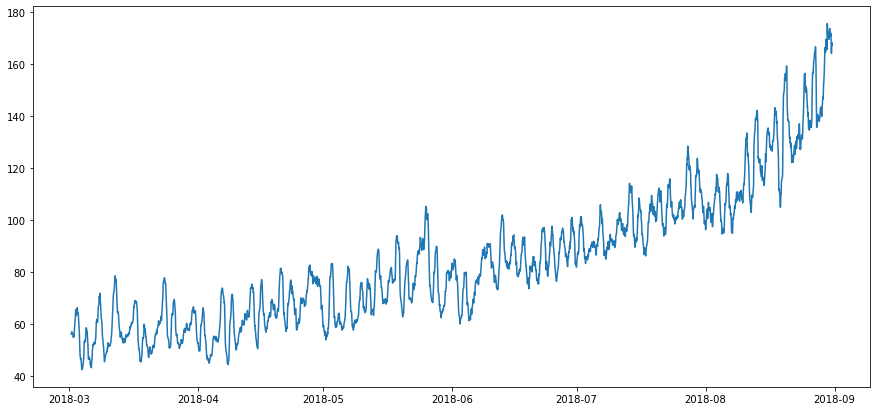

In [13]:
plt.figure(figsize=(15, 7))
plt.plot(decomposed.trend)
plt.show()

<b>Тренд виден, но он не очень гладкий, скорее всего депомпозиция не отделила его в чистом виде от остального сигнала</b>
* С марта активность возрастает к августу-сентябрю. Видимо бархатный период для отдыхающий во многих странах или волна командировок

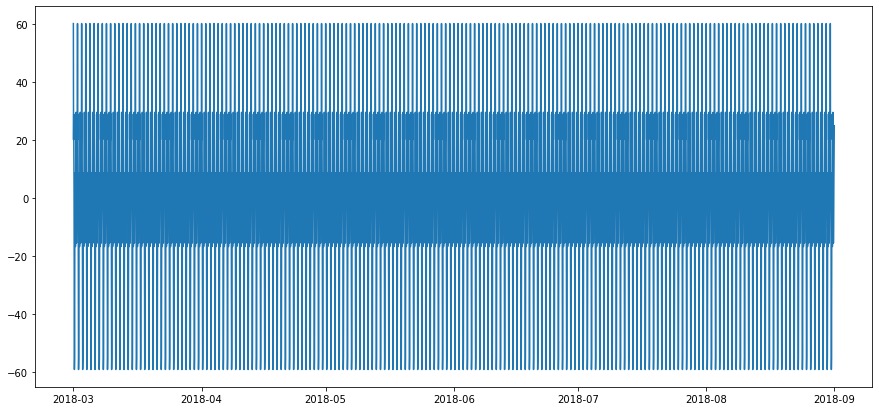

In [14]:
plt.figure(figsize=(15, 7))
plt.plot(decomposed.seasonal)
plt.show()

<b>Хорошо видно ежедневную сезонность:</b>
* в 12 ночи график достигает пика(самый актуальный период), а в 6 утра находится в самой нижней точке(самый тихий период). Переход межну ними резкий
* активность возрастает в 9 утра. 
* в 16:00 происходит скачок и спад на 18:00
* от 18:00 непрерывно возрастает к 12 ночи

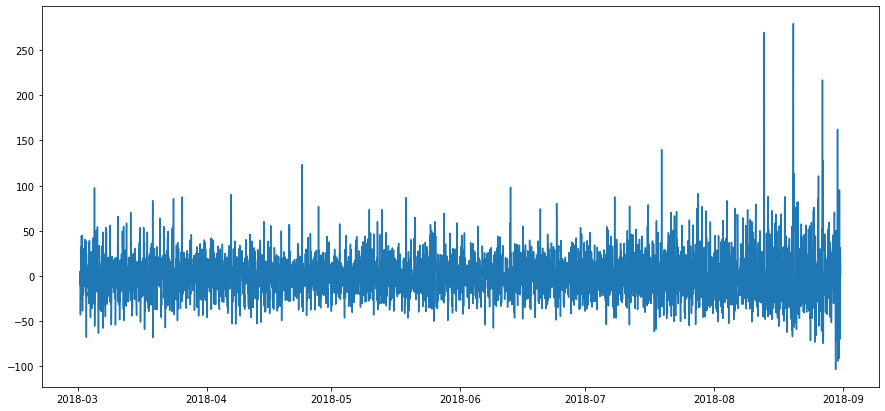

In [15]:
plt.figure(figsize=(15, 7))
plt.plot(decomposed.resid)
plt.show()

<b>В остатках мы видим нормально распределённый шум, но величина разброса от -50 до 50, как и у сезонности, хотя остатки должны быть меньше по разбросу(по отношению к другим компонентам)</b>

### Подготовка данных

<b>Разделим данные на тренировочные и тестовые, с пропорцией 90/10</b>

In [16]:
train, test = train_test_split(df_hour, shuffle=False, test_size=0.1)
train = train.dropna()

train_features = train.drop(columns='num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop(columns='num_orders', axis=1)
test_target = test['num_orders']

<b>Проверим правильность разбивки данных</b>

In [17]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

## Обучение

<b>Введём функцию вычисления метрики RMSE</b>

In [18]:
def rmse_metric(target, pred):
    return mean_squared_error(target, pred) ** 0.5

<b>Для начала спрогнозируем временные ряды без обучения</b>

In [19]:
print("Количество заказов такси в час:", test['num_orders'].mean())

<b>Константная модель(медиана)</b>

In [20]:
pred_median = np.ones(test.shape) * train['num_orders'].median()
print("RMSE:", rmse_metric(test, pred_median))

<b>значение x(t) прогнозируется предыдущим значением ряда x(t-1) - "Завтра будет, как вчера"</b>

In [21]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[train.shape[0]-1]
print("RMSE:", rmse_metric(test, pred_previous))

<b>Напишем функцию создания признаков для горизонта прогнозирования</b>

In [22]:
def make_features(data, max_lag, rolling_mean_size):
#    data['year'] = data.index.year
#    data['month'] = data.index.month
#    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

<b>Добавим с помощью функции новые признаки, после разобъём на тренировочную и тестовую</b>

In [73]:
new_df = make_features(df_hour, 12, 24)

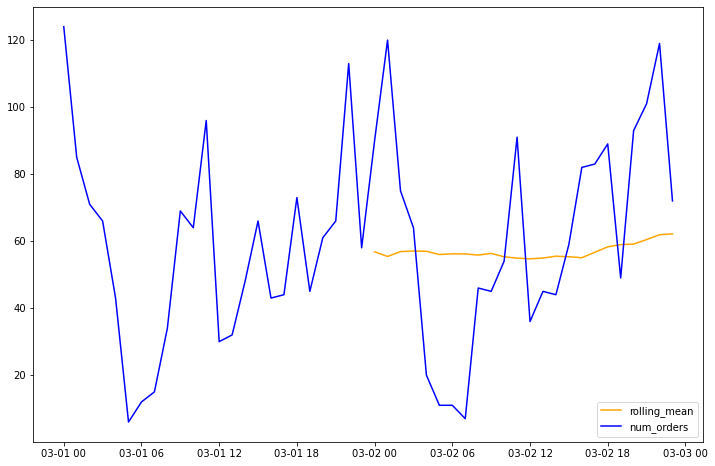

In [74]:
plt.figure(figsize=(12, 8))
plt.plot(new_df['2018-03-01':'2018-03-02']['rolling_mean'], color='orange', label='rolling_mean')
plt.plot(new_df['2018-03-01':'2018-03-02']['num_orders'], color='blue', label='num_orders')
plt.legend()
plt.show()

In [75]:
train_ts, test_ts = train_test_split(new_df, shuffle=False, test_size=0.1)
train_ts = train_ts.dropna()
test_ts = test_ts.dropna()
tr_features = train_ts.drop(columns='num_orders', axis=1)
tr_target = train_ts['num_orders']
tst_features = test_ts.drop(columns='num_orders', axis=1)
tst_target = test_ts['num_orders']

In [76]:
display(train_ts.shape, test_ts.shape)

In [77]:
display(tr_features.shape, tr_target.shape)

In [78]:
model = LinearRegression()
model.fit(tr_features, tr_target)

In [79]:
pred_train = model.predict(tr_features)
train_rmse = rmse_metric(tr_target, pred_train)
print("RMSE обучающей выборки:", train_rmse)

<b>Обучим модель XGBRegressor</b>

In [80]:
xgb_model = xgb.XGBRegressor(colsample_bytree=0.8, gamma=0.3, max_depth=2, min_child_weight=4, 
                             subsample=1.0)
xgb_model.fit(tr_features, tr_target)

In [81]:
xgb_pred_train = xgb_model.predict(tr_features)
xgb_rmse = rmse_metric(tr_target, xgb_pred_train)
print("RMSE обучающей выборки:", xgb_rmse)

In [82]:
tscv = TimeSeriesSplit(n_splits=3)

In [83]:
train_data, valid_data = train_test_split(train_ts, shuffle=False, test_size=0.5)
features_train = train_data.drop(columns='num_orders', axis=1)
target_train = train_data['num_orders']
features_val = valid_data.drop(columns='num_orders', axis=1)
target_val = valid_data['num_orders']

In [84]:
#params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
#'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}
#grid = GridSearchCV(xgb_model, params, verbose=1, n_jobs=-1, cv=tscv)
#grid.fit(features_train, target_train)

In [85]:
display(grid.best_score_, grid.best_params_)

## Тестирование

In [86]:
pred_test = model.predict(tst_features)
test_rmse = rmse_metric(tst_target, pred_test)
print("RMSE тестовой выборки: ", test_rmse)

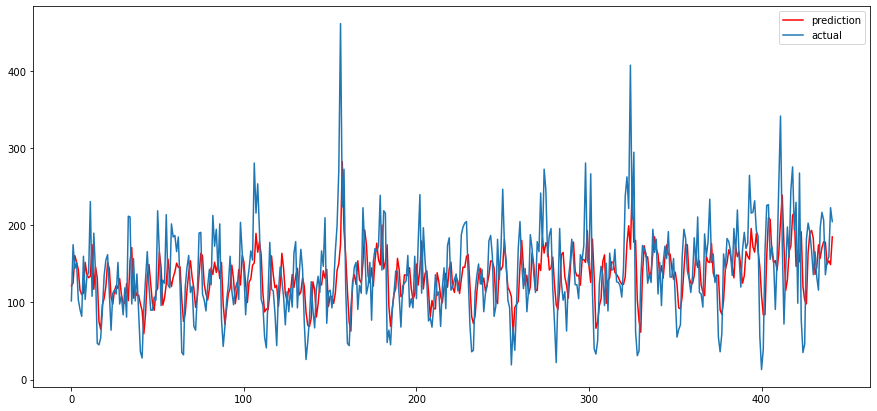

In [87]:
plt.figure(figsize=(15, 7))
plt.plot(pred_test, "r", label="prediction")
plt.plot(tst_target.values, label="actual")
plt.legend()
plt.show()

In [88]:
xgb_pred_test = xgb_model.predict(tst_features)
xgb_test_rmse = rmse_metric(tst_target, xgb_pred_test)
print("RMSE тестовой выборки: ", xgb_test_rmse)

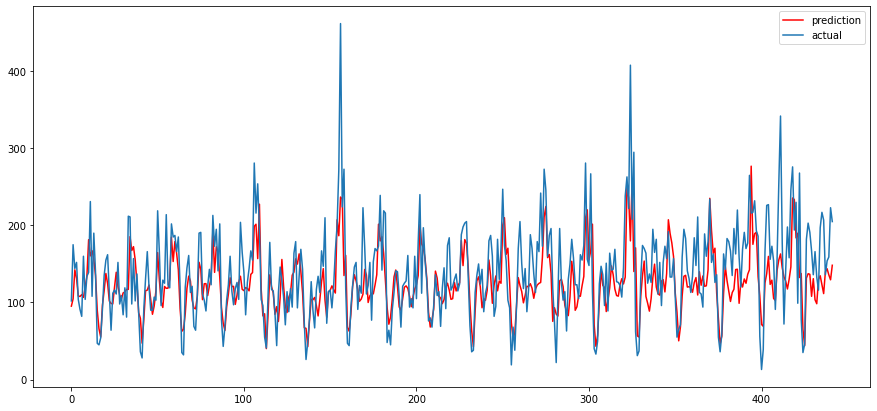

In [89]:
plt.figure(figsize=(15, 7))
plt.plot(xgb_pred_test, "r", label="prediction")
plt.plot(tst_target.values, label="actual")
plt.legend()
plt.show()

## Выводы:

* LinearRegression - RMSE обучающей выборки: <b>30</b>, RMSE тестовой выборки:  <b>51</b>
* XGBRegressor - RMSE обучающей выборки: <b>21</b>, RMSE тестовой выборки:  <b>48</b>